In [14]:
#pip install git+https://github.com/msmalmir/scTransID.git

In [5]:
# loading required packages
import scTransID
import torch
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim
import scanpy as sc
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from scTransID.data_utils import load_data, preprocess_data, split_data
from scTransID.model import TransformerModel
from scTransID.train import train_model
from scTransID.evaluation import evaluate_on_query
import time

# Paths to sample data 
train_path = './Datasets/hArtery/hArtery_train_adata.h5ad'
test_path = './Datasets/hArtery/hArtery_test_adata.h5ad'

cell_type_key = "celltype"
# loading and preprocess data
train_adata, query_adata = load_data(train_path, test_path)
X_train, y_train, X_query, le = preprocess_data(train_adata, query_adata, cell_type_key)
X_train_tensor, y_train_tensor, X_val_tensor, y_val_tensor = split_data(X_train, y_train)

# Initialize model, loss function, and optimizer
num_genes = X_train_tensor.shape[1]
num_classes = len(le.classes_)
model = TransformerModel(num_genes=num_genes, num_classes=num_classes)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0001)

# Load data into DataLoader
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)

# Train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=5)

# Convert query dataset and true labels to PyTorch tensors
X_query_tensor = torch.tensor(X_query, dtype=torch.float32)
y_query = query_adata.obs['celltype'].values  # Ensure true labels are available
y_query_encoded = le.transform(y_query)  # Transform true labels to encoded form

# Evaluate the model on the query dataset
predicted_celltypes, accuracy, f1 = evaluate_on_query(model, X_query_tensor, y_query_encoded, le)

# Display the results
print("Predicted cell types for the query dataset:")
print(predicted_celltypes)
print(f"Accuracy on query dataset: {accuracy:.2f}")
print(f"F1 score on query dataset: {f1:.2f}")

Epoch 1/5, Loss: 0.1846, Val Loss: 0.1185, Val Accuracy: 96.62%
Epoch 2/5, Loss: 0.0550, Val Loss: 0.1042, Val Accuracy: 97.17%
Epoch 3/5, Loss: 0.0329, Val Loss: 0.1144, Val Accuracy: 97.08%
Epoch 4/5, Loss: 0.0233, Val Loss: 0.1258, Val Accuracy: 97.31%
Epoch 5/5, Loss: 0.0116, Val Loss: 0.1277, Val Accuracy: 97.67%
Predicted cell types for the query dataset:
['Myeloid' 'T' 'T' ... 'T' 'Myeloid' 'Plasma']
Accuracy on query dataset: 0.96
F1 score on query dataset: 0.92


In [6]:
# Add predicted cell types to query_adata
query_adata.obs['predicted_celltypes'] = predicted_celltypes

# UMAP visualization for true vs predicted labels
sc.pp.neighbors(query_adata) 
sc.pp.pca(query_adata, n_comps=50)  
sc.tl.umap(query_adata)  

C:\Users\mlw043\AppData\Roaming\Python\Python310\site-packages\scanpy\tools\_utils.py:41: UserWarning: You’re trying to run this on 3000 dimensions of `.X`, if you really want this, set `use_rep='X'`.
         Falling back to preprocessing with `sc.pp.pca` and default params.
  warnings.warn(


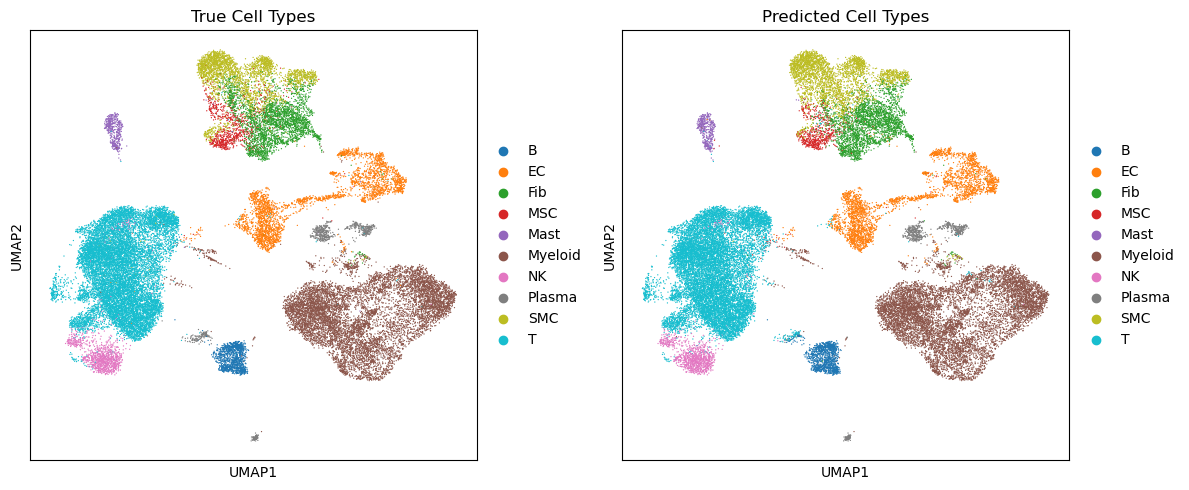

In [8]:
# Create subplots (1 row, 2 columns)
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot UMAP of true labels
sc.pl.umap(query_adata, color='celltype', title='True Cell Types', show=False, ax=ax[0])

# Plot UMAP of predicted labels
sc.pl.umap(query_adata, color='predicted_celltypes', title='Predicted Cell Types', show=False, ax=ax[1])

# Display the plots side by side
plt.tight_layout()
plt.show()

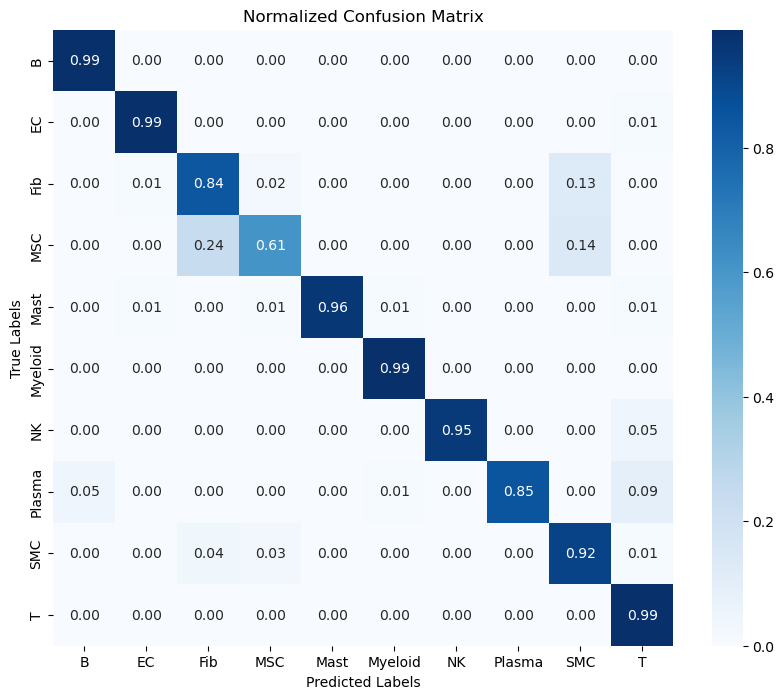

In [13]:
# Ensure celltype columns are categorical and handle NaNs as strings if needed
query_adata.obs['celltype'] = query_adata.obs['celltype'].astype('category')
query_adata.obs['predicted_celltypes'] = query_adata.obs['predicted_celltypes'].astype('category')

# Get the full set of unique labels
all_cell_types = np.union1d(query_adata.obs['celltype'].cat.categories, query_adata.obs['predicted_celltypes'].cat.categories)

# Create and normalize the confusion matrix
conf_matrix = confusion_matrix(query_adata.obs['celltype'], query_adata.obs['predicted_celltypes'], labels=all_cell_types)
conf_matrix_normalized = np.round(conf_matrix / conf_matrix.sum(axis=1, keepdims=True), 2)

# Plot the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix_normalized, annot=True, cmap="Blues", xticklabels=all_cell_types, yticklabels=all_cell_types, fmt='.2f')
plt.title('Normalized Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()
